In [ ]:
import pandas as pd
import nltk
import numpy as np
from collections import Counter
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
import random
import spacy
from sklearn.cluster import KMeans

nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('stopwords')
!python -m spacy download en_core_web_md

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 33.5 MB 1.5 MB/s 
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')


# Input Data

In [ ]:
ms_df = pd.read_json('movie_synopsis.json').T
mi_df = pd.read_csv('movie_info.csv')
mi_df = mi_df.rename(columns={'locale_id':'local_id'})
print(ms_df.columns, '\n', mi_df.columns, '\n')

data_df = pd.merge(ms_df, mi_df, how='outer', on='local_id')
data_df

Index(['imdbID', 'plot_synopsis', 'local_id', 'plot_source'], dtype='object') 
 Index(['local_id', 'title', 'id_imdb', 'genre_imdb'], dtype='object') 



,imdbID,plot_synopsis,local_id,plot_source,title,id_imdb,genre_imdb
0,tt0114709,A boy called Andy Davis (voice: John Morris) u...,1.0,imdb,Toy Story (1995),tt0114709,Animation|Adventure|Comedy|Family|Fantasy
1,tt0113189,"The story opens in 1986, in the Cold War Sovie...",2.0,imdb,GoldenEye (1995),tt0113189,Action|Adventure|Thriller
2,tt0113101,The film begins with Ted the Bellhop (Tim Roth...,3.0,imdb,Four Rooms (1995),tt0113101,Comedy
3,tt0113161,Chilli Palmer (John Travolta) is a loan shark ...,4.0,imdb,Get Shorty (1995),tt0113161,Comedy|Crime|Thriller
4,tt0112722,After giving a guest lecture on criminal psych...,5.0,imdb,Copycat (1995),tt0112722,Drama|Mystery|Thriller
...,...,...,...,...,...,...,...
1677,tt0120594,Alan (Jared Harris) is a schoolteacher in Lond...,1679.0,wiki,B. Monkey (1998),tt0120594,Crime|Drama|Romance|Thriller
1678,tt0120148,The film follows Helen Quilley (Gwyneth Paltro...,1680.0,imdb,Sliding Doors (1998),tt0120148,Comedy|Drama|Fantasy|Romance
1679,tt0111804,,1681.0,wiki,You So Crazy (1994),tt0111804,Documentary|Comedy
1680,tt0102855,,1682.0,wiki,Scream of Stone (Schrei aus Stein) (1991),tt0102855,Drama


# Pre-processing

## Eliminate not-needed rows and columns:

In [ ]:
eliminated_df = data_df.copy()
null_columns=eliminated_df.columns[eliminated_df.isna().any()]
eliminated_df[null_columns].isna().sum().sort_values(ascending=False)

genre_imdb       83
imdbID           81
id_imdb          81
plot_source       4
plot_synopsis     1
dtype: int64

In [ ]:
eliminated_df = eliminated_df.dropna()
eliminated_df.shape

(1596, 7)

In [ ]:
eliminated_df[eliminated_df['id_imdb'] != eliminated_df['imdbID']].shape[0]

0

In [ ]:
eliminated_df = eliminated_df.drop(columns=['id_imdb', 'imdbID'])
eliminated_df.shape

(1596, 5)

## Stemming VS Lemmatization

In [ ]:
ps = PorterStemmer()
lemmatizer = WordNetLemmatizer()

print("nltk stemming results:")
print("rocks :", ps.stem("rocks"))
print("exhaustive :", ps.stem("exhaustive"))
print("corpora :", ps.stem("corpora"))
print("better :", ps.stem("better"))

print("\nnltk lemmatization results:")
print("rocks :", lemmatizer.lemmatize("rocks"))
print("exhaustive :", lemmatizer.lemmatize("exhaustive"))
print("corpora :", lemmatizer.lemmatize("corpora"))
# a denotes adjective in "pos"
print("better :", lemmatizer.lemmatize("better", pos ="a"))

nltk stemming results:
rocks : rock
exhaustive : exhaust
corpora : corpora
better : better

nltk lemmatization results:
rocks : rock
exhaustive : exhaustive
corpora : corpus
better : good


## Text pre-processing

In [ ]:
stop_words = set(nltk.corpus.stopwords.words('english'))
def text_preprocessing(string):
  # tokenize text
  tokens = nltk.tokenize.RegexpTokenizer(r'\w+').tokenize(string)
  # lower case all words
  tokens = [w.lower() for w in tokens]
  # remove stop words
  tokens = [w for w in tokens if not w in stop_words]
  # remove single-char words like 'd
  tokens = [w for w in tokens if len(w)>1]
  # remove words that include numbers
  tokens = [w for w in tokens if not any(c.isdigit() for c in w)]
  # lemmatization on each token
  tokens = [lemmatizer.lemmatize(w) for w in tokens]
  # join tokens with space to create new string
  new_string = ' '.join(tokens)
  return new_string

In [ ]:
pp_df = eliminated_df.copy()
# run the above pre-processing on titles and synopsis of the whole data
for index, row in pp_df.iterrows():
  row['plot_synopsis'] = text_preprocessing(row['plot_synopsis'])
  row['title'] = text_preprocessing(row['title'])

In [ ]:
# some compares before and after text pre-processing
for i in range(5):
  r = random.randint(0, pp_df.shape[0])
  try:
    print('before:\n', data_df['plot_synopsis'][r], '\n')
    print('after:\n', pp_df['plot_synopsis'][r], '\n', 20*'-')
  except:
    continue

before:
 Dawn Wiener (Heather Matarazzo) is a shy, unattractive, unpopular 12-year-old 7th grader in a middle-class suburban community in New Jersey. Her older brother Mark (Matthew Faber) is a nerdy 11th grade high school student who plays the clarinet in a garage band and shuns girls in order to prepare for college. Dawn's younger sister Missy (Daria Kalinina) is a seven-year-old spoiled, manipulative little girl who pesters Dawn and dances happily in a tutu. Their mother (Angela Pietropinto) is a shrewish, overbearing woman who dotes on Missy and always sides with her in disputes with Dawn. Their father is a meek, selfish businessman who always sides with Dawn's mother. Dawn's only friend is an effeminate fifth-grade boy named Ralphy (Dimitri DeFresco), with whom she shares a dilapidated clubhouse in her backyard.Dawn's life in junior high is even more miserable: all of classmates call her names and cover her locker with derisive graffiti, the cheerleaders call her a lesbian, an abr

## Numeric genres

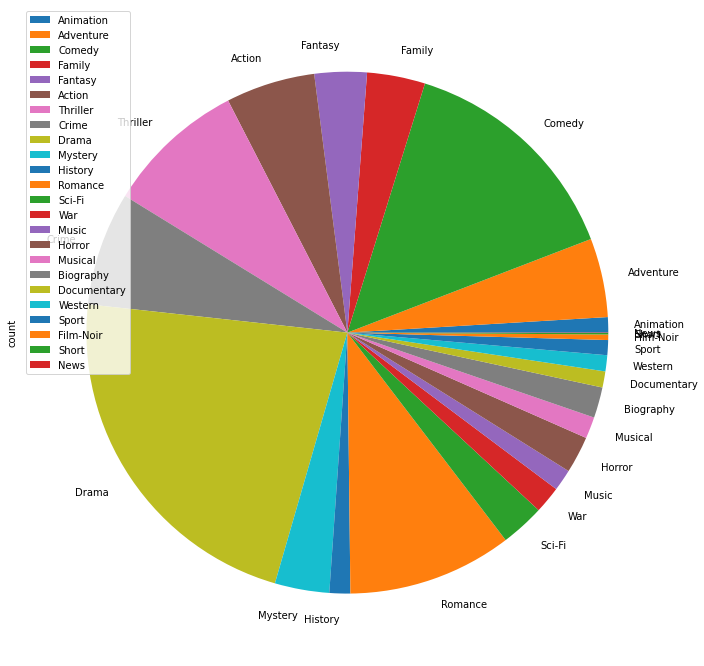

In [ ]:
all_genres = []
# collect all genres to see what we have
for index, row in pp_df.iterrows():
  all_genres += row['genre_imdb'].split('|')
genres = list(set(all_genres))
pd.DataFrame.from_dict(Counter(all_genres), orient='index', columns=['count']).plot.pie(y='count', figsize=(12,12))

In [ ]:
for index, row in pp_df.iterrows():
  temp = np.zeros((24,))
  row_genres = row['genre_imdb'].split('|')
  for g in row_genres:
    temp[genres.index(g)] = 1
  row['genre_imdb'] = temp

## Numeric plot_source

In [ ]:
pp_df['plot_source'].replace({'imdb':0, 'wiki':1},inplace=True)
pp_df = pp_df.astype({'local_id': 'int64'})
pp_df

,plot_synopsis,local_id,plot_source,title,genre_imdb
0,boy called andy davis voice john morris us toy...,1,0,toy story,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,story open cold war soviet union british secre...,2,0,goldeneye,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,film begin ted bellhop tim roth room filled ho...,3,0,four room,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,chilli palmer john travolta loan shark living ...,4,0,get shorty,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
4,giving guest lecture criminal psychology local...,5,0,copycat,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...,...
1675,angel celebrates birth daughter taking first h...,1677,1,sweet nothing,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1677,alan jared harris schoolteacher london also mo...,1679,1,monkey,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1678,film follows helen quilley gwyneth paltrow you...,1680,0,sliding door,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1679,,1681,1,crazy,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ..."


# Feature Extraction

In [ ]:
text_features = []
# Load the spacy model that we have installed
nlp = spacy.load('en_core_web_md')
# Replace the text fields with average embedding of their tokens
for index, row in pp_df.iterrows():
  text = pp_df['plot_synopsis'][index] + pp_df['title'][index]
  text_features.append(np.array(nlp(text).vector))

In [ ]:
fe_df = pp_df.drop(columns=['plot_synopsis', 'title', 'local_id']).copy()
fe_df['text_features'] = text_features
fe_df

,plot_source,genre_imdb,text_features
0,0,"[1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.7138522, 0.073373705, -0.1398024, -0.10776..."
1,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.67880213, 0.08571929, -0.015693752, -0.004..."
2,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.6802255, 0.07970264, -0.024893358, -0.0727..."
3,0,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.70416576, 0.12861355, -0.06847692, -0.0346..."
4,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.718952, 0.12190968, -0.0152674485, -0.0501..."
...,...,...,...
1675,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.6812775, 0.09497944, -0.14746328, -0.07139..."
1677,1,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.70034236, 0.17377904, -0.052543465, -0.060..."
1678,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[-0.7026811, 0.15511484, -0.055853795, -0.0132..."
1679,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...","[-0.67887, -0.35292, -0.32589, -0.11129, -0.24..."


# Clustering

In [ ]:
# Put all the features together as a numpy array
temp = fe_df.to_numpy()
dataset = []
for i in range(temp.shape[0]):
    dataset.append(np.concatenate((np.array([temp[i][0]]), temp[i][1], temp[i][2])))
dataset = np.array(dataset)
dataset.shape

(1596, 325)

In [ ]:
k_means = KMeans(n_clusters=8, random_state=0).fit(dataset)

In [ ]:
Counter(k_means.labels_)

Counter({0: 194, 1: 105, 2: 232, 3: 311, 4: 199, 5: 315, 6: 61, 7: 179})

In [ ]:
eliminated_df['label'] = list(k_means.labels_)
eliminated_df

,plot_synopsis,local_id,plot_source,title,genre_imdb,label
0,A boy called Andy Davis (voice: John Morris) u...,1.0,imdb,Toy Story (1995),Animation|Adventure|Comedy|Family|Fantasy,1
1,"The story opens in 1986, in the Cold War Sovie...",2.0,imdb,GoldenEye (1995),Action|Adventure|Thriller,0
2,The film begins with Ted the Bellhop (Tim Roth...,3.0,imdb,Four Rooms (1995),Comedy,5
3,Chilli Palmer (John Travolta) is a loan shark ...,4.0,imdb,Get Shorty (1995),Comedy|Crime|Thriller,2
4,After giving a guest lecture on criminal psych...,5.0,imdb,Copycat (1995),Drama|Mystery|Thriller,2
...,...,...,...,...,...,...
1675,Angel celebrates the birth of his daughter by ...,1677.0,wiki,Sweet Nothing (1995),Drama,3
1677,Alan (Jared Harris) is a schoolteacher in Lond...,1679.0,wiki,B. Monkey (1998),Crime|Drama|Romance|Thriller,2
1678,The film follows Helen Quilley (Gwyneth Paltro...,1680.0,imdb,Sliding Doors (1998),Comedy|Drama|Fantasy|Romance,4
1679,,1681.0,wiki,You So Crazy (1994),Documentary|Comedy,5


# Post-Processing

In [ ]:
def plot_for_label(label):
  label_genres = []
  for index, row in eliminated_df.iterrows():
    if row['label'] == label:
      label_genres += row['genre_imdb'].split('|')
  
  label_genres_count = dict(Counter(label_genres))
  my_dict = {}
  for k in sorted(genres):
    try:
      my_dict[k] = label_genres_count[k]
    except:
      my_dict[k] = 0
  print(my_dict)

  print('genres for label=', label,':')
  pd.DataFrame.from_dict(my_dict, orient='index', columns=['count']).plot.pie(y='count', figsize=(7,7))

{'Action': 146, 'Adventure': 73, 'Animation': 2, 'Biography': 1, 'Comedy': 15, 'Crime': 27, 'Documentary': 1, 'Drama': 27, 'Family': 3, 'Fantasy': 22, 'Film-Noir': 0, 'History': 1, 'Horror': 38, 'Music': 0, 'Musical': 0, 'Mystery': 19, 'News': 0, 'Romance': 10, 'Sci-Fi': 79, 'Short': 0, 'Sport': 2, 'Thriller': 138, 'War': 2, 'Western': 9}
genres for label= 0 :


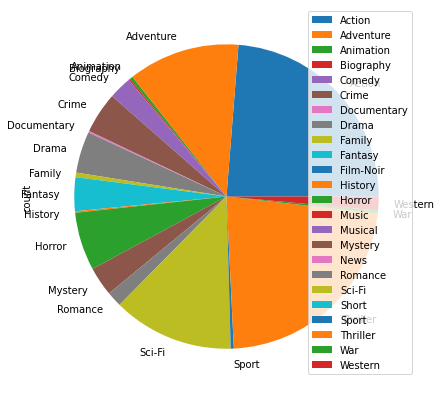

In [ ]:
plot_for_label(0)

{'Action': 10, 'Adventure': 85, 'Animation': 35, 'Biography': 0, 'Comedy': 63, 'Crime': 2, 'Documentary': 1, 'Drama': 29, 'Family': 99, 'Fantasy': 51, 'Film-Noir': 0, 'History': 3, 'Horror': 0, 'Music': 1, 'Musical': 32, 'Mystery': 5, 'News': 0, 'Romance': 24, 'Sci-Fi': 10, 'Short': 1, 'Sport': 5, 'Thriller': 0, 'War': 1, 'Western': 6}
genres for label= 1 :


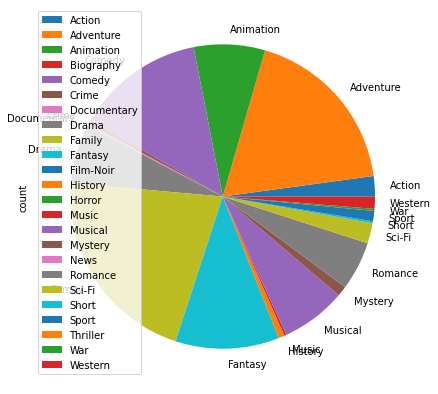

In [ ]:
plot_for_label(1)

{'Action': 53, 'Adventure': 4, 'Animation': 1, 'Biography': 3, 'Comedy': 22, 'Crime': 190, 'Documentary': 2, 'Drama': 198, 'Family': 0, 'Fantasy': 7, 'Film-Noir': 9, 'History': 3, 'Horror': 13, 'Music': 2, 'Musical': 0, 'Mystery': 68, 'News': 0, 'Romance': 16, 'Sci-Fi': 6, 'Short': 0, 'Sport': 2, 'Thriller': 200, 'War': 2, 'Western': 3}
genres for label= 2 :


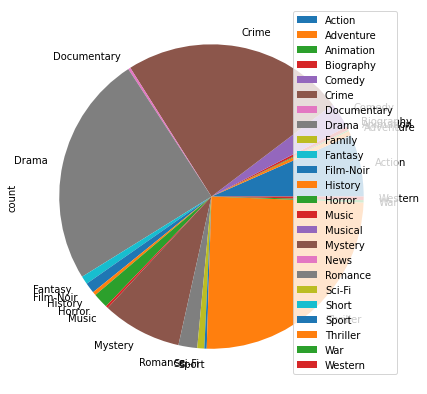

In [ ]:
plot_for_label(2)

{'Action': 11, 'Adventure': 25, 'Animation': 0, 'Biography': 52, 'Comedy': 1, 'Crime': 16, 'Documentary': 28, 'Drama': 258, 'Family': 12, 'Fantasy': 20, 'Film-Noir': 2, 'History': 35, 'Horror': 30, 'Music': 19, 'Musical': 1, 'Mystery': 17, 'News': 1, 'Romance': 0, 'Sci-Fi': 7, 'Short': 2, 'Sport': 13, 'Thriller': 10, 'War': 36, 'Western': 16}
genres for label= 3 :


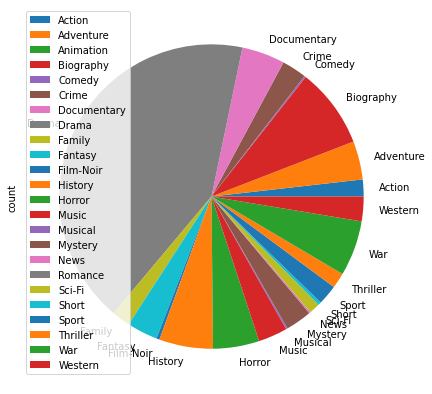

In [ ]:
plot_for_label(3)

{'Action': 3, 'Adventure': 5, 'Animation': 0, 'Biography': 1, 'Comedy': 199, 'Crime': 16, 'Documentary': 0, 'Drama': 108, 'Family': 5, 'Fantasy': 10, 'Film-Noir': 0, 'History': 3, 'Horror': 1, 'Music': 11, 'Musical': 13, 'Mystery': 6, 'News': 0, 'Romance': 199, 'Sci-Fi': 4, 'Short': 0, 'Sport': 2, 'Thriller': 7, 'War': 3, 'Western': 1}
genres for label= 4 :


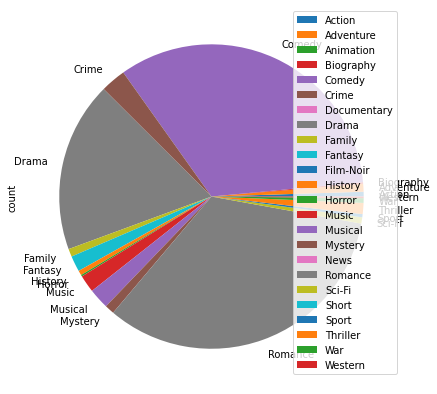

In [ ]:
plot_for_label(4)

{'Action': 15, 'Adventure': 13, 'Animation': 2, 'Biography': 5, 'Comedy': 315, 'Crime': 43, 'Documentary': 3, 'Drama': 145, 'Family': 32, 'Fantasy': 22, 'Film-Noir': 0, 'History': 1, 'Horror': 13, 'Music': 14, 'Musical': 6, 'Mystery': 10, 'News': 0, 'Romance': 0, 'Sci-Fi': 12, 'Short': 0, 'Sport': 14, 'Thriller': 9, 'War': 9, 'Western': 4}
genres for label= 5 :


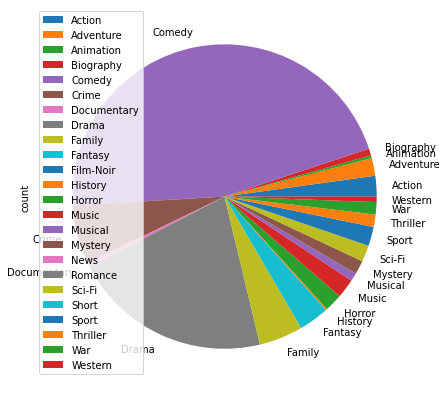

In [ ]:
plot_for_label(5)

{'Action': 0, 'Adventure': 1, 'Animation': 1, 'Biography': 4, 'Comedy': 19, 'Crime': 8, 'Documentary': 9, 'Drama': 45, 'Family': 1, 'Fantasy': 1, 'Film-Noir': 0, 'History': 2, 'Horror': 1, 'Music': 5, 'Musical': 2, 'Mystery': 6, 'News': 0, 'Romance': 22, 'Sci-Fi': 0, 'Short': 1, 'Sport': 0, 'Thriller': 3, 'War': 3, 'Western': 0}
genres for label= 6 :


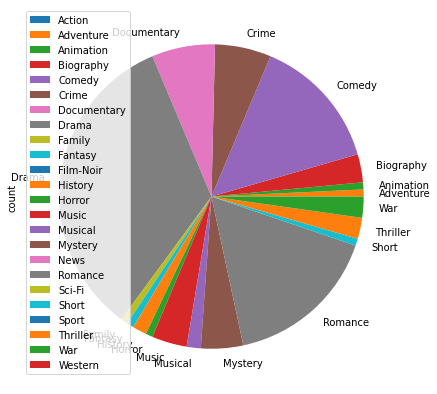

In [ ]:
plot_for_label(6)

{'Action': 6, 'Adventure': 10, 'Animation': 1, 'Biography': 18, 'Comedy': 0, 'Crime': 9, 'Documentary': 0, 'Drama': 173, 'Family': 7, 'Fantasy': 10, 'Film-Noir': 4, 'History': 9, 'Horror': 5, 'Music': 7, 'Musical': 5, 'Mystery': 18, 'News': 0, 'Romance': 179, 'Sci-Fi': 2, 'Short': 0, 'Sport': 3, 'Thriller': 16, 'War': 18, 'Western': 5}
genres for label= 7 :


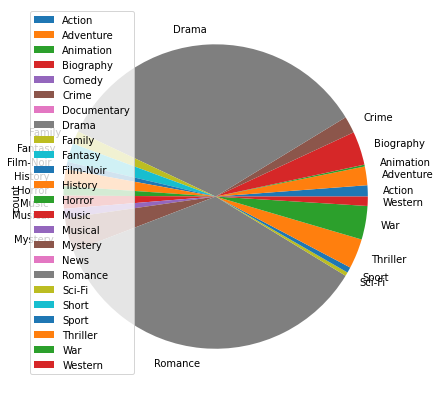

In [ ]:
plot_for_label(7)